In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

import warnings
warnings.filterwarnings('ignore')

## Read and merge the data

In [2]:
DATA_PATH = 'data/'
JOB_POSTINGS_PATH = DATA_PATH + 'gsearch_jobs.csv'
COMPANIES_PATH = DATA_PATH + 'companies.csv'
INDUSTRIES_PATH = DATA_PATH + 'industries.csv'
COMPANY_INDUSTRY_PATH = DATA_PATH + 'company_industries.csv'
EMPLOYEE_COUNTS_PATH = DATA_PATH + 'employee_counts.csv'
JOB_LEVEL_VERIFY_PATH = DATA_PATH + 'verify_job_level_extraction.csv'
PROCESSED_DATA_PATH = DATA_PATH + 'dataframe_after_preprocessing.csv'

In [3]:
df = pd.read_csv(JOB_POSTINGS_PATH, index_col=0)
df.drop(columns=['index'], inplace=True)

In [4]:
df_nondupe = df.drop_duplicates(subset=['title', 'company_name', 'location', 'description'])
print('There are', len(df_nondupe), 'non-duplicate job postings.')
non_empty_count = df['salary_standardized'].notnull() & (df['salary_standardized'] != '')
non_empty_count = non_empty_count.sum()
print('In which there are', non_empty_count, 'postings with non-empty salary attribute.')

There are 41379 non-duplicate job postings.
In which there are 9125 postings with non-empty salary attribute.


In [5]:
df.columns

Index(['title', 'company_name', 'location', 'via', 'description', 'extensions',
       'job_id', 'thumbnail', 'posted_at', 'schedule_type', 'work_from_home',
       'salary', 'search_term', 'date_time', 'search_location', 'commute_time',
       'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max',
       'salary_hourly', 'salary_yearly', 'salary_standardized',
       'description_tokens'],
      dtype='object')

In [6]:
companies = pd.read_csv(COMPANIES_PATH)
industries = pd.read_csv(INDUSTRIES_PATH)
company_industries = pd.read_csv(COMPANY_INDUSTRY_PATH)
employee_counts = pd.read_csv(EMPLOYEE_COUNTS_PATH)

In [7]:
companies.columns

Index(['company_id', 'name', 'description', 'company_size', 'state', 'country',
       'city', 'zip_code', 'address', 'url'],
      dtype='object')

In [8]:
companies.rename(columns={'description': 'company_description'}, inplace = True)

In [9]:
df_merged = pd.merge(df_nondupe, companies, left_on='company_name', right_on='name', how='left')
df_merged['company_id'] = df_merged['company_id'].apply(lambda x: int(x) if pd.notnull(x) else np.nan)
df_merged = pd.merge(df_merged, company_industries, on='company_id', how='left')
df_merged = pd.merge(df_merged, industries, on='industry', how='left')

In [10]:
df_merged.columns

Index(['title', 'company_name', 'location', 'via', 'description', 'extensions',
       'job_id', 'thumbnail', 'posted_at', 'schedule_type', 'work_from_home',
       'salary', 'search_term', 'date_time', 'search_location', 'commute_time',
       'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max',
       'salary_hourly', 'salary_yearly', 'salary_standardized',
       'description_tokens', 'company_id', 'name', 'company_description',
       'company_size', 'state', 'country', 'city', 'zip_code', 'address',
       'url', 'industry', 'industry_id', 'parent_industry'],
      dtype='object')

In [11]:
non_empty_count = df_merged['company_id'].notnull() & (df_merged['company_id'] != '')
non_empty_count = non_empty_count.sum()
print('There are', non_empty_count, 'out of', len(df_merged), 'job postings with the basic information of company.')
non_empty_count = df_merged['parent_industry'].notnull() & (df_merged['industry'] != '')
non_empty_count = non_empty_count.sum()
print('There are', non_empty_count, 'out of', len(df_merged), 'job postings with the industry information of company.')

There are 18366 out of 41622 job postings with the basic information of company.
There are 18282 out of 41622 job postings with the industry information of company.


In [12]:
non_empty_count = df_merged['description'].notnull() & (df_merged['description'] != '')
non_empty_count = non_empty_count.sum()
print('There are', non_empty_count, 'out of', len(df_merged), 'job postings with non-empty job description.')

There are 41622 out of 41622 job postings with non-empty job description.


In [13]:
df_merged = df_merged[['title', 'company_name', 'location', 'via', 'description', 'extensions',
       'posted_at', 'schedule_type', 'work_from_home',
       'salary', 'search_term', 'date_time', 'search_location', 'commute_time',
       'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max',
       'salary_hourly', 'salary_yearly', 'salary_standardized',
       'description_tokens', 'name', 'company_description',
       'company_size', 'state', 'country', 'city', 'parent_industry']]

In [14]:
df_merged.head()

,title,company_name,location,via,description,extensions,posted_at,schedule_type,work_from_home,salary,...,salary_yearly,salary_standardized,description_tokens,name,company_description,company_size,state,country,city,parent_industry
0,Data Analyst,Cisco Meraki,Anywhere,via LinkedIn,"As the leader in cloud-managed IT, Cisco Merak...","['22 hours ago', 'Work from home', 'Full-time'...",22 hours ago,Full-time,True,NaN,...,NaN,NaN,"['aws', 'sql', 'tableau']",Cisco Meraki,"At Cisco Meraki, we create intuitive technolog...",5.0,California,US,San Francisco,Technology
1,Entry Level - Business Data Analyst (Remote),Midwest Staffing,Anywhere,via LinkedIn,As a Senior Business Analyst you will contribu...,"['53 minutes ago', 'Work from home', 'Full-tim...",53 minutes ago,Full-time,True,NaN,...,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Data Analyst/Researcher,"Amyx, Inc.",United States,via Indeed,Overview:\n\nAmyx is seeking to hire a Data An...,"['3 hours ago', 'Full-time']",3 hours ago,Full-time,NaN,NaN,...,NaN,NaN,"['azure', 'sql', 'excel']",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Data analyst/AI expert to help build a website...,Upwork,Anywhere,via Upwork,I am looking for someone to help me build an A...,"['23 hours ago', 'Work from home', 'Contractor']",23 hours ago,Contractor,True,NaN,...,NaN,NaN,['excel'],NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Data Analyst,Bank Street College of Education,United States,via Higher Education Recruitment Consortium (H...,Position Vacancy – Data Analyst to support the...,"['20 hours ago', 'Full-time']",20 hours ago,Full-time,NaN,NaN,...,NaN,NaN,"['powerpoint', 'excel']",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Split salary into pay and rate
df_merged[['salary_pay', 'salary_rate']] = df_merged['salary'].str.split(pat=' ', n=1, expand=True)

# Clean salary_pay by removing commas, dollar signs, and spaces
df_merged['salary_pay'] = df_merged['salary_pay'].str.replace(',', '').str.replace('$', '').str.replace(' ', '')

# Handle salary ranges and convert to numeric
df_merged['salary_avg'] = np.where(df_merged['salary_pay'].str.contains("–"), np.nan, df_merged['salary_pay'])
df_merged['salary_min'] = np.where(df_merged['salary_pay'].str.contains("–"), df_merged['salary_pay'], np.nan)
df_merged[['salary_min', 'salary_max']] = df_merged.salary_min.str.split(pat="–", n=1, expand=True)

# Convert K to thousands and handle numeric conversion
for column in ['salary_avg', 'salary_min', 'salary_max']:
    df_merged[column] = df_merged[column].str.replace("K", "000")
    df_merged[column] = pd.to_numeric(df_merged[column], errors='coerce')

# Calculate average salary for ranges
df_merged['salary_avg'] = np.where(df_merged['salary_min'].notnull(),
                                   (df_merged['salary_min'] + df_merged['salary_max']) / 2,
                                   df_merged['salary_avg'])

# Calculate hourly and yearly salaries
df_merged['salary_hourly'] = np.where(df_merged['salary_rate'] == 'an hour', df_merged['salary_avg'], np.nan)
df_merged['salary_yearly'] = np.where(df_merged['salary_rate'] == 'a year', df_merged['salary_avg'], np.nan)

# Standardize salary to annual
salary_rate = {'a year': 1, 'an hour': 2080, 'a month': 12}
df_merged['salary_standardized'] = df_merged.apply(
    lambda row: row['salary_avg'] * salary_rate.get(row['salary_rate'], np.nan) if pd.notnull(row['salary_avg']) else np.nan,
    axis=1
)

# Used to check results as built above
salary_df = df_merged[~df_merged['salary'].isnull()]
salary_df = salary_df[['company_name', 'salary', 'salary_pay', 'salary_rate', 'salary_avg', 'salary_min', 'salary_max', 'salary_standardized', 'salary_hourly', 'salary_yearly']]
pd.set_option('display.max_rows', salary_df.shape[0]+1)
salary_df.head(10)

,company_name,salary,salary_pay,salary_rate,salary_avg,salary_min,salary_max,salary_standardized,salary_hourly,salary_yearly
5,Marathon TS,80K–90K a year,80K–90K,a year,85000.0,80000.0,90000.0,85000.0,NaN,85000.0
18,Upwork,20–40 an hour,20–40,an hour,30.0,20.0,40.0,62400.0,30.0,NaN
22,Insight Global,40–65 an hour,40–65,an hour,52.5,40.0,65.0,109200.0,52.5,NaN
47,Upwork,75–125 an hour,75–125,an hour,100.0,75.0,125.0,208000.0,100.0,NaN
57,Upwork,75–100 an hour,75–100,an hour,87.5,75.0,100.0,182000.0,87.5,NaN
67,Mastermind.com,90K–110K a year,90K–110K,a year,100000.0,90000.0,110000.0,100000.0,NaN,100000.0
135,Upwork,40–75 an hour,40–75,an hour,57.5,40.0,75.0,119600.0,57.5,NaN
141,OQ Point LLC,43–48 an hour,43–48,an hour,45.5,43.0,48.0,94640.0,45.5,NaN
146,Upwork,17–46 an hour,17–46,an hour,31.5,17.0,46.0,65520.0,31.5,NaN
188,Upwork,40–75 an hour,40–75,an hour,57.5,40.0,75.0,119600.0,57.5,NaN


## Data Cleaning and EDA

In [16]:
# Remove leading and trailing spaces
df_merged['location'] = df_merged['location'].str.strip()

# Standardize the format (e.g., remove extra spaces within the string)
df_merged['location'] = df_merged['location'].str.replace(r'\s+', ' ', regex=True)

# Clean skills
df_merged['description_tokens'] = df_merged['description_tokens'].apply(lambda x: re.findall(r"'(.*?)'", x))

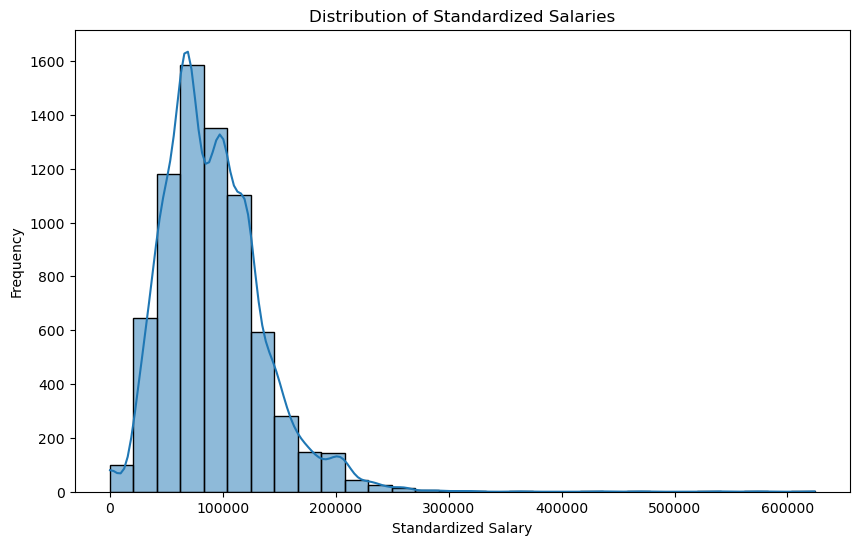

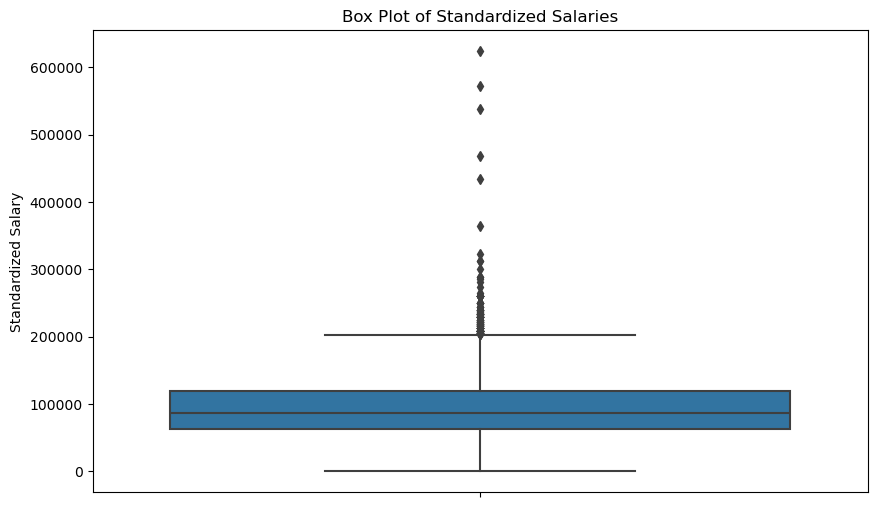

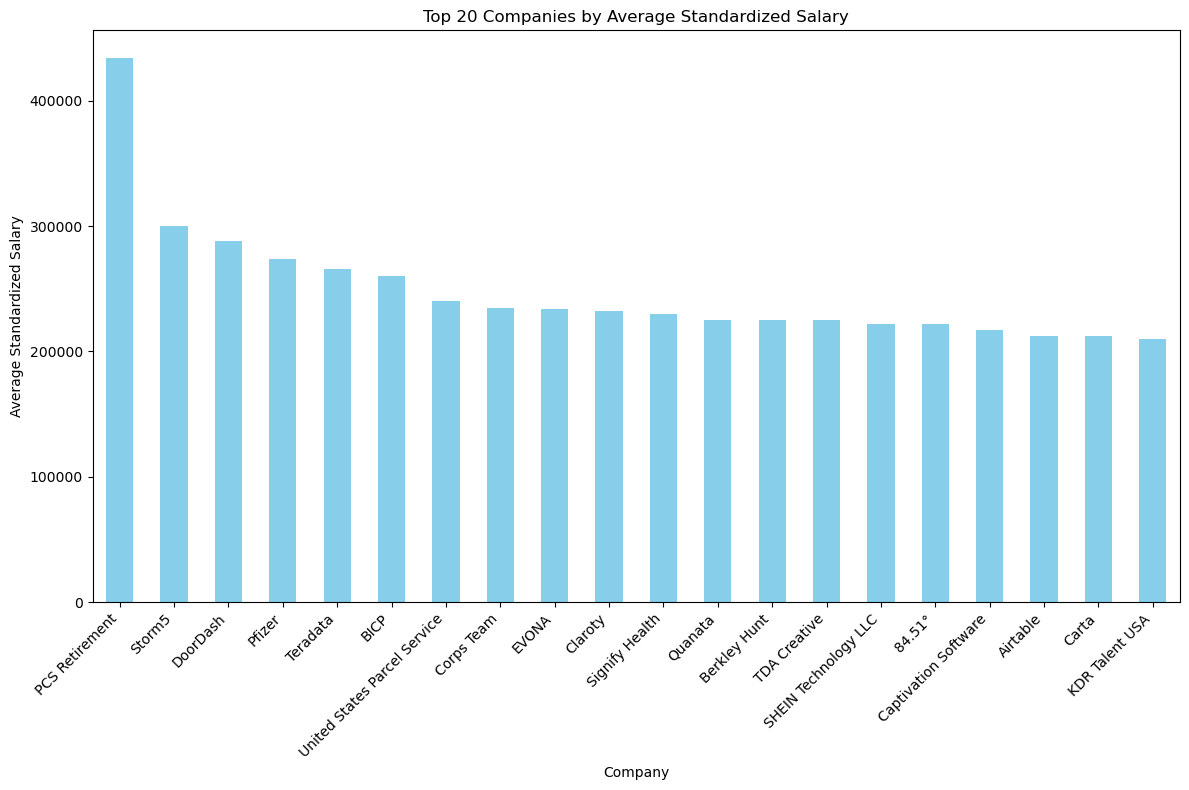

In [17]:
# Histogram of Salary Standardized
plt.figure(figsize=(10, 6))
sns.histplot(salary_df['salary_standardized'], bins=30, kde=True)
plt.xlabel('Standardized Salary')
plt.ylabel('Frequency')
plt.title('Distribution of Standardized Salaries')
plt.show()

# Box Plot of Salary Standardized
plt.figure(figsize=(10, 6))
sns.boxplot(y=salary_df['salary_standardized'])
plt.ylabel('Standardized Salary')
plt.title('Box Plot of Standardized Salaries')
plt.show()

# Bar Plot of Average Salary by Company
average_salary_by_company = salary_df.groupby('company_name')['salary_standardized'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12, 8))
average_salary_by_company.plot(kind='bar', color='skyblue')
plt.xlabel('Company')
plt.ylabel('Average Standardized Salary')
plt.title('Top 20 Companies by Average Standardized Salary')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
df_merged[['salary_avg', 'salary_min', 'salary_max', 'salary_standardized']].describe()

,salary_avg,salary_min,salary_max,salary_standardized
count,7219.000000,6784.000000,6784.000000,7219.000000
mean,36801.064758,29139.207127,44651.996123,91531.368368
std,53173.869806,44229.235658,64630.722831,44536.232573
min,2.100000,1.800000,2.400000,25.200000
25%,32.427500,18.460000,45.000000,62400.000000
50%,57.500000,44.550000,75.000000,86320.000000
75%,80500.000000,69983.500000,100000.000000,118560.000000
max,434500.000000,275000.000000,850000.000000,624000.000000


In [19]:
def extract_experience(description):
    # Regular expression to find patterns like "X years", "X+ years", "X- years", "X years of experience" 1
    pattern = r'(\d+\s*[\+\-]?\s*years?)'
    # pattern = r'(\d+)\s*[-+]?[\s]*years?[\s]*(?:of\s*experience)?'
    matches = re.findall(pattern, description.lower())
    if matches:
        # Extract the numeric part and convert to integer
        years = [int(re.findall(r'\d+', match)[0]) for match in matches]
        return max(years)  # Return the maximum years of experience found
    return np.nan

# Apply the function to the 'description' column
df_merged['Years_of_Experience'] = df_merged['description'].apply(extract_experience)

# Display the first few rows to check the results
df_merged[['description', 'Years_of_Experience']].head()

,description,Years_of_Experience
0,"As the leader in cloud-managed IT, Cisco Merak...",3.0
1,As a Senior Business Analyst you will contribu...,NaN
2,Overview:\n\nAmyx is seeking to hire a Data An...,5.0
3,I am looking for someone to help me build an A...,NaN
4,Position Vacancy – Data Analyst to support the...,5.0


In [20]:
non_empty_count = df_merged['Years_of_Experience'].notnull() & (df_merged['Years_of_Experience'] != '')
non_empty_count = non_empty_count.sum()
print('There are', non_empty_count, 'out of', len(df_merged), 'job postings with Years_of_Experience in job description.')

There are 24478 out of 41622 job postings with Years_of_Experience in job description.


In [21]:
correlation = df_merged[['Years_of_Experience', 'salary_standardized']].dropna().corr().iloc[0, 1]
print(f'Correlation between salary and YOE: {correlation}')

Correlation between salary and YOE: -0.04567625424586261


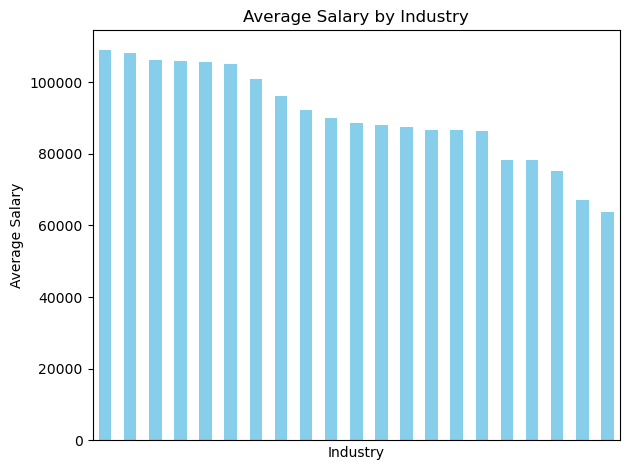

In [22]:
average_salary = df_merged.groupby('parent_industry')['salary_standardized'].mean()
average_salary_sorted = average_salary.sort_values(ascending=False)
average_salary_sorted.plot(kind='bar', color='skyblue')

plt.xlabel('Industry')
plt.ylabel('Average Salary')
plt.title('Average Salary by Industry')
plt.xticks([])
plt.tight_layout()

plt.show()

## Findings

### What are the most in-demand skills across industries?

In [23]:
from collections import Counter


# Flatten the list of tokens and count unique values
all_tokens = [token for sublist in df_merged['description_tokens'] for token in sublist]
print(all_tokens[0])
token_counts = Counter(all_tokens)

# Convert to DataFrame for better readability
token_counts_df = pd.DataFrame(token_counts.items(), columns=['Token', 'Count']).sort_values(by='Count', ascending=False)

# Display the top 20 most common tokens
print(token_counts_df.head(20))

aws
          Token  Count
1           sql  21130
4         excel  13467
12       python  12777
16     power_bi  11768
2       tableau  11337
18            r   7734
9           sas   3602
5    powerpoint   3002
23         word   2954
3         azure   2668
10    snowflake   2512
0           aws   2488
22        spark   2220
13       looker   1856
61           go   1632
41  spreadsheet   1574
19        scala   1527
15          sap   1481
56         spss   1256
51            c   1182


### Which cities have the highest demand for Data Scientists?

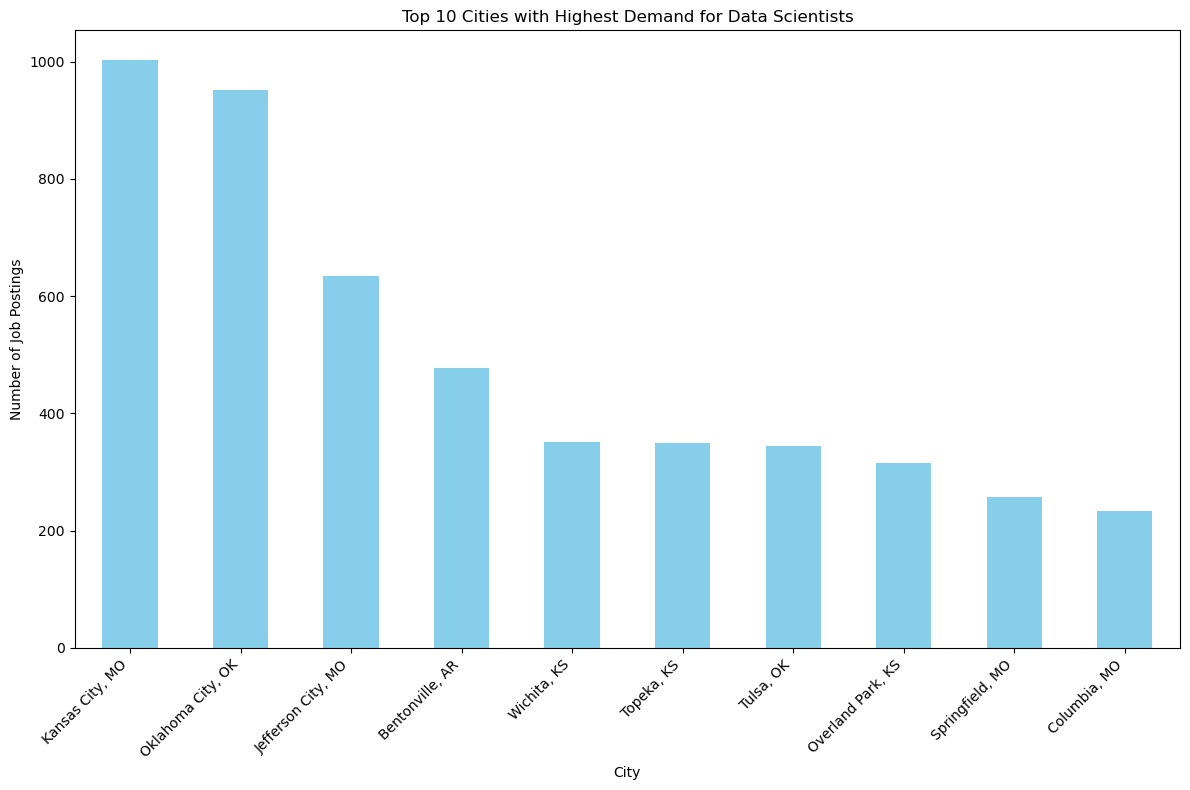

In [24]:
# Count the number of job postings for Data Scientists in each city
# exclude Anywhere and Remote and United States when counting the number of most popular locations
city_demand = df_merged['location'].value_counts().drop(['Anywhere', 'United States']).head(10)

# Plot the top 10 cities with the highest demand for Data Scientists
plt.figure(figsize=(12, 8))
city_demand.plot(kind='bar', color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Job Postings')
plt.title('Top 10 Cities with Highest Demand for Data Scientists')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

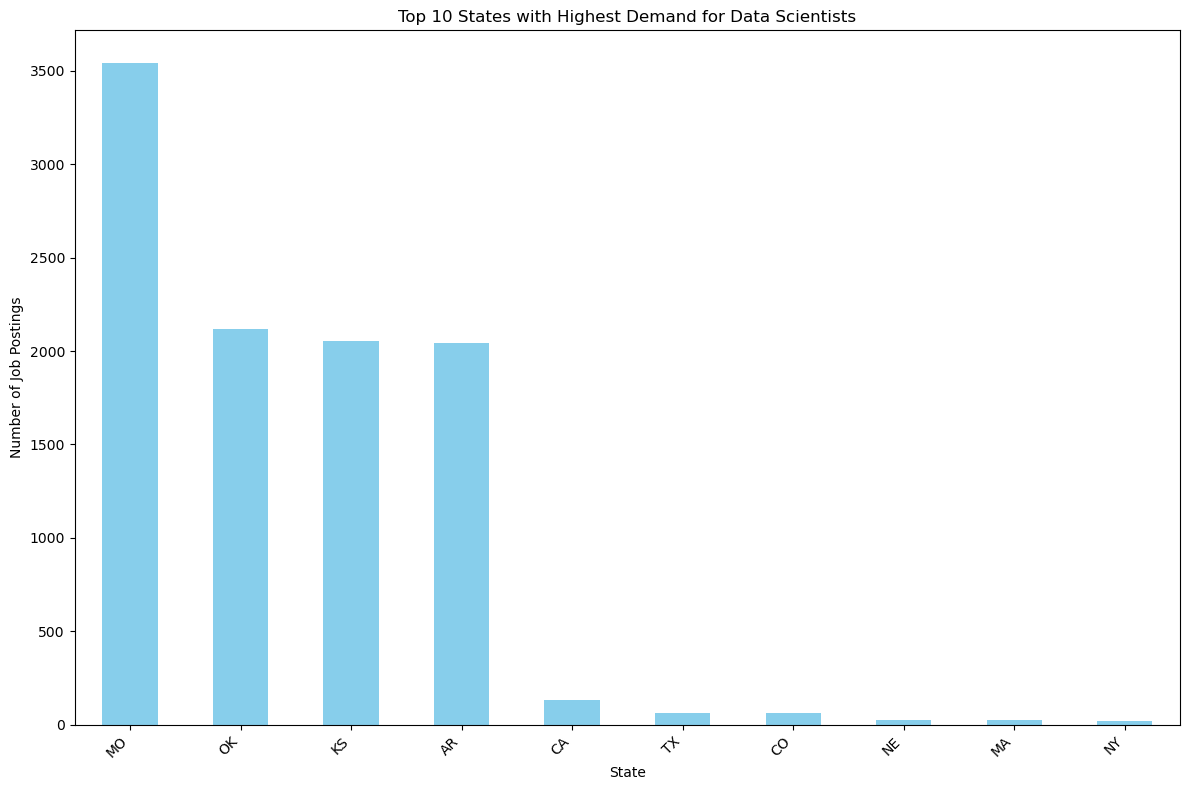

In [25]:
# extract the states from the location
df_merged['state'] = df_merged['location'].str.extract(r',\s*([A-Z]{2})')[0]
# Count the number of job postings for Data Scientists in each state
state_demand = df_merged['state'].value_counts().dropna().head(10)
# Plot the top 10 states with the highest demand for Data Scientists
plt.figure(figsize=(12, 8))
state_demand.plot(kind='bar', color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Job Postings')
plt.title('Top 10 States with Highest Demand for Data Scientists')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
state_demand

state
MO    3540
OK    2119
KS    2053
AR    2043
CA     131
TX      65
CO      65
NE      24
MA      23
NY      17
Name: count, dtype: int64

### What proportion of job postings are for remote roles? Which industries are leading in remote work adoption?

Proportion of job postings that are remote: 48.86%
Top industries leading in remote work adoption:
parent_industry
Technology                         0.685921
Nonprofit                          0.532468
Environmental                      0.531250
Community and Personal Services    0.499672
Media & Entertainment              0.498270
Legal                              0.481481
Healthcare                         0.389553
Transportation & Logistics         0.380282
Finance                            0.361358
Automotive                         0.349398
Name: work_from_home, dtype: float64


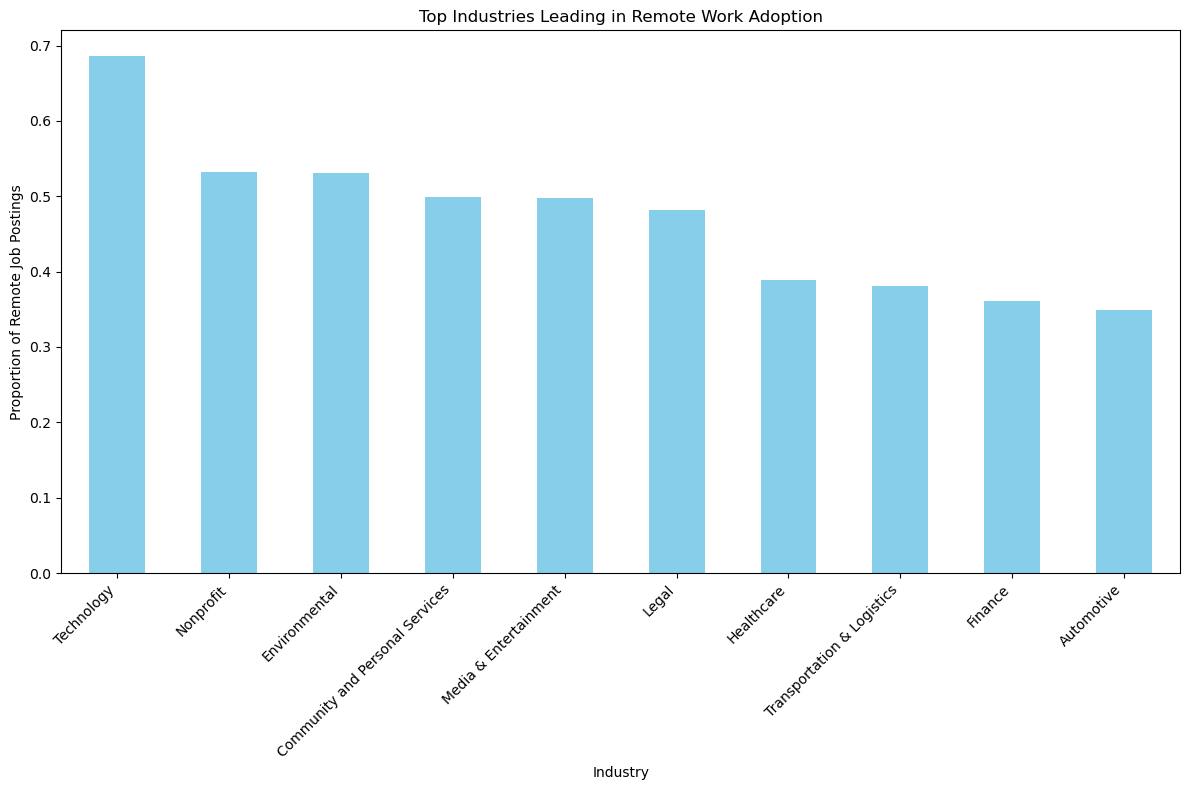

In [27]:
# Calculate the proportion of remote job postings
remote_jobs = df_merged['work_from_home'].fillna(False).astype(bool)
remote_proportion = remote_jobs.mean()
print(f'Proportion of job postings that are remote: {remote_proportion:.2%}')

# Calculate the proportion of remote job postings by industry
remote_by_industry = df_merged.groupby('parent_industry')['work_from_home'].apply(lambda x: x.fillna(False).astype(bool).mean()).sort_values(ascending=False)

# Display the top industries leading in remote work adoption
print('Top industries leading in remote work adoption:')
print(remote_by_industry.head(10))

# Plot the top industries leading in remote work adoption
plt.figure(figsize=(12, 8))
remote_by_industry.head(10).plot(kind='bar', color='skyblue')
plt.xlabel('Industry')
plt.ylabel('Proportion of Remote Job Postings')
plt.title('Top Industries Leading in Remote Work Adoption')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### What are the seasonal patterns in job postings? What is the basic trend in recent years? Specifically, what about Data Scientist entry level jobs? (decomposition)

<Figure size 1200x800 with 0 Axes>

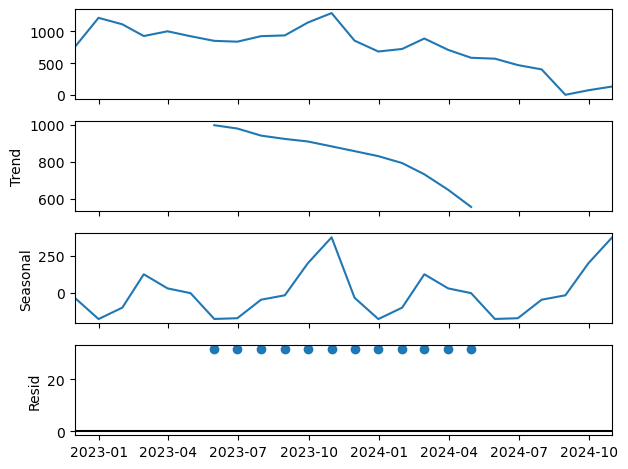

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the date_time column is in datetime format
df_merged['date_time'] = pd.to_datetime(df_merged['date_time'])

# Filter for Data Scientist entry-level jobs or 0 - 1 years of experience
entry_level_jobs = df_merged[df_merged['Years_of_Experience'].between(0, 1) | df_merged['Years_of_Experience'].isnull() | (df_merged['description'].str.contains('entry level', case=False))]

# Group by month and count the number of job postings
monthly_jobs = entry_level_jobs.resample('M', on='date_time').size()

# Decompose the time series
decomposition = seasonal_decompose(monthly_jobs, model='additive')

# Plot the decomposition
plt.figure(figsize=(12, 8))
decomposition.plot()
plt.show()

### Filter 4 states' postings

In [29]:
df_merged = df_merged[df_merged['state'].isin(['MO', 'OK', 'KS', 'AR'])]
state_demand = df_merged['state'].value_counts().dropna().head(10)
state_demand

state
MO    3540
OK    2119
KS    2053
AR    2043
Name: count, dtype: int64

## Feature Engineering

### Text-based Features - Job Level

In [30]:
def extract_job_level(description):
    description = description.lower()
    if any(keyword in description for keyword in ['senior', 'lead', 'manager', 'director']):
        return 'Senior'
    elif any(keyword in description for keyword in ['mid-level', 'associate', 'regular']):
        return 'Mid'
    elif any(keyword in description for keyword in ['entry-level', 'junior', 'intern', 'trainee']):
        return 'Entry'
    else:
        return 'Unspecified'
df_merged['job_level'] = df_merged['title'].apply(extract_job_level)
df_merged['job_level'] = df_merged['description'].apply(extract_job_level)

In [31]:
df_merged.loc[(df_merged['job_level'] == 'Unspecified') & (df_merged['Years_of_Experience'].isin([0, 1, 2])), 'job_level'] = 'Entry'

In [32]:
df_merged['job_level'].value_counts()

job_level
Senior         7458
Unspecified    1084
Entry           611
Mid             602
Name: count, dtype: int64

In [33]:
non_empty_count = df_merged['job_level'].notnull() & (df_merged['job_level'] != 'Unspecified')
non_empty_count = non_empty_count.sum()
print('There are', non_empty_count, 'out of', len(df_merged), 'job postings with job_level in job description.')

There are 8671 out of 9755 job postings with job_level in job description.


In [34]:
df_one_hot_level = pd.get_dummies(df_merged['job_level'], prefix='level')
df_merged = pd.concat([df_merged, df_one_hot_level], axis=1)

In [35]:
# Verify the job-level extraction
sample_df = df_merged[['title', 'description', 'job_level']].sample(n=30, random_state=42)
sample_df.to_csv(JOB_LEVEL_VERIFY_PATH)

### Clean Salary Data

In [36]:
# fill df_merged salary standardized by job-level and location
print('Number of missing values in salary_standardized before:', df_merged['salary_standardized'].isnull().sum())
salary_standardized_filling = df_merged.groupby(['job_level', 'location'])['salary_standardized'].transform(lambda x: x.fillna(x.mean()))
print('Number of missing values in salary_standardized after:', salary_standardized_filling.isnull().sum())
df_merged['salary_standardized'] = salary_standardized_filling
print('length of df_merged:', len(df_merged))
df_merged.dropna(subset=['salary_standardized'], inplace=True)
print('length of df_merged after dropping NaN:', len(df_merged))


Number of missing values in salary_standardized before: 8785
Number of missing values in salary_standardized after: 1909
length of df_merged: 9755
length of df_merged after dropping NaN: 7846


In [37]:
df_merged = df_merged.reset_index(drop=True)

### Text-based Features - TF-IDF

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf.fit_transform(df_merged['description'])

In [39]:
TFIDF_PATH = DATA_PATH + 'tfidf_mtx.csv'
if not os.path.exists(TFIDF_PATH):
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names_out())
    tfidf_df.to_csv(TFIDF_PATH, index=False)

### Categorical Features - Encoding for Industry and Location

In [40]:
major_cities_lst = ['Kansas City, MO', 'St. Louis, MO', 'Springfield, MO', 'Columbia, MO', 'Independence, MO', "Lee's Summit, MO", 
                    'Oklahoma City, OK', 'Tulsa, OK', 'Norman, OK', 'Broken Arrow, OK', 'Edmond, OK', 'Lawton, OK', 
                    'Wichita, KS', 'Overland Park, KS', 'Kansas City, KS', 'Olathe, KS', 'Topeka, KS', 'Lawrence, KS', 
                    'Little Rock, AR', 'Fayetteville, AR', 'Fort Smith, AR', 'Springdale, AR', 'Jonesboro, AR', 'Rogers, AR']
df_merged['location_encoded'] = df_merged['location'].apply(lambda x: x if x in major_cities_lst else 'minor_cities')

df_one_hot_location = pd.get_dummies(df_merged['location_encoded'], prefix='city')

df_merged = pd.concat([df_merged, df_one_hot_location], axis=1)

In [41]:
df_one_hot_industry = pd.get_dummies(df_merged['parent_industry'], prefix='industry')
df_merged = pd.concat([df_merged, df_one_hot_location, df_one_hot_industry], axis=1)

In [42]:
df_merged['parent_industry'].value_counts()

parent_industry
Retail                             1075
Technology                          555
Finance                             442
Community and Personal Services     413
Healthcare                          371
Telecommunications                  308
Energy & Utilities                  135
Government & Public Sector          134
Education                           101
Aerospace & Defense                  81
Construction                         70
Consumer Goods                       64
Manufacturing                        64
Real Estate                          56
Media & Entertainment                24
Automotive                           19
Transportation & Logistics           10
Legal                                 8
Environmental                         6
Nonprofit                             6
Hospitality                           5
Name: count, dtype: int64

### Numerical Features - Job Description Length

In [43]:
# df_merged['average_length'] = df_merged['description'].str.len().mean()

### Numerical Features - Number of Required Technical Skills

In [44]:
df_merged['num_skills'] = df_merged['description_tokens'].apply(len)

### Text-based Features - Soft Skills

In [45]:
# imports
import spacy
from spacy.matcher import PhraseMatcher

# load default skills data base
from skillNer.general_params import SKILL_DB
# import skill extractor
from skillNer.skill_extractor_class import SkillExtractor

# init params of skill extractor
nlp = spacy.load("en_core_web_sm")
# init skill extractor
skill_extractor = SkillExtractor(nlp, SKILL_DB, PhraseMatcher)


loading full_matcher ...
loading abv_matcher ...
loading full_uni_matcher ...
loading low_form_matcher ...
loading token_matcher ...


In [46]:
import json

with open('skill_db_relax_20.json', 'r') as f:
    json_data = json.load(f)

soft_skills_list = []

soft_skill_types = ["Soft Skill"]

for skill_id, skill_data in json_data.items():
    if skill_data['skill_type'] in soft_skill_types:
        # Add both high and low surface forms to the soft skills list
        soft_skills_list.append(skill_data['skill_name'].lower())

soft_skills_list = list(set(soft_skills_list))
# print("Soft Skills List:", soft_skills_list)

In [47]:
# Function to find soft skills in each job description
def find_soft_skills(job_description):
    found_skills = [skill for skill in soft_skills_list if skill in job_description.lower()]
    return found_skills

# Apply the function to each job description in the DataFrame
df_merged['required_soft_skills'] = df_merged['description'].apply(find_soft_skills)


## Saving processed data

In [55]:
columns_to_drop = ['title', 'company_name', 'location', 'via', 'extensions', 
                   'posted_at', 'schedule_type', 'search_term', 'date_time', 
                   'search_location', 'commute_time', 'name', 'company_description', 
                   'state', 'country', 'city', 'parent_industry', 'job_level', 
                   'location_encoded', 'average_length']

df_merged = df_merged.drop(columns=[col for col in columns_to_drop if col in df_merged.columns])

In [56]:
df_merged.to_csv(PROCESSED_DATA_PATH, index=False)